For simulating D'Hondt's algorithm, I followed Appendix A of Vermeij's Bachelor Thesis.

In [1]:
!pip install qiskit
!pip install pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136816 sha256=6785bbdbfa1c71a2c4ecaec49ba016165bb928d9fea1ae17d24f0e46ee94caf6
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc


In [2]:
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, execute, BasicAer
import sys
import numpy as np

# import other libraries
# https://qiskit.org/documentation/tutorials/circuits_advanced/02_operators_overview.html
from qiskit.compiler import transpile
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.quantum_info import process_fidelity

from qiskit.extensions import RXGate, XGate, CXGate, UnitaryGate

In [3]:
def calculate_theta(n):
    return 1 / 2 * np.arccos(1 / np.sqrt(n))

In [4]:
def new_f_gate(circ, q, i, j, n):
    theta = calculate_theta(n)
    F = Operator(
        [[1, 0, 0, 0],
        [0, np.cos(theta * 2), 0, np.sin(theta * 2)],
        [0, 0, 1, 0],
        [0, np.sin(theta * 2), 0, - np.cos(theta * 2)]]
    )
    circ.append(F, [i, j])
    circ.barrier()

In [5]:
# Define a function for the F gate (Vermeij)
def f_gate(circ, q, i, j, n, k=1):
    theta = np.arccos(np.sqrt(1 / (n - k + 1)))
    circ.ry(-theta, q[j])
    circ.cz(q[i], q[j])
    circ.ry(theta, q[j])
    circ.barrier()


In [6]:
def create_w_state(circ, q, i, n):
    if (n == 3):
        new_f_gate(circ, q, i, i + 1, 3)
        circ.cx(q[i + 1], q[i])
        new_f_gate(circ, q, i + 1, i + 2, 2)
        circ.cx(q[i + 2], q[i + 1])
    elif (n > 3):
        new_f_gate(circ, q, i, i + 1, n)
        create_w_state(circ, q, i + 1, n - 1)
        for j in range(n - 1):
            circ.cx(q[i + j + 1], q[i])
    circ.barrier()

In [7]:
# Set the size of the network
size = 6

In [8]:
# Create the quantum registers and classical registers for measurement
q = QuantumRegister(size)
c = ClassicalRegister(size)

/usr/local/lib/python3.10/dist-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


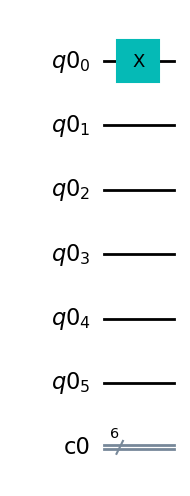

In [9]:
# Create the circuit with all registers and perform a Pauli X gate on the first qubit
circ = QuantumCircuit(q, c)
circ.x(0)

circ.draw('mpl')

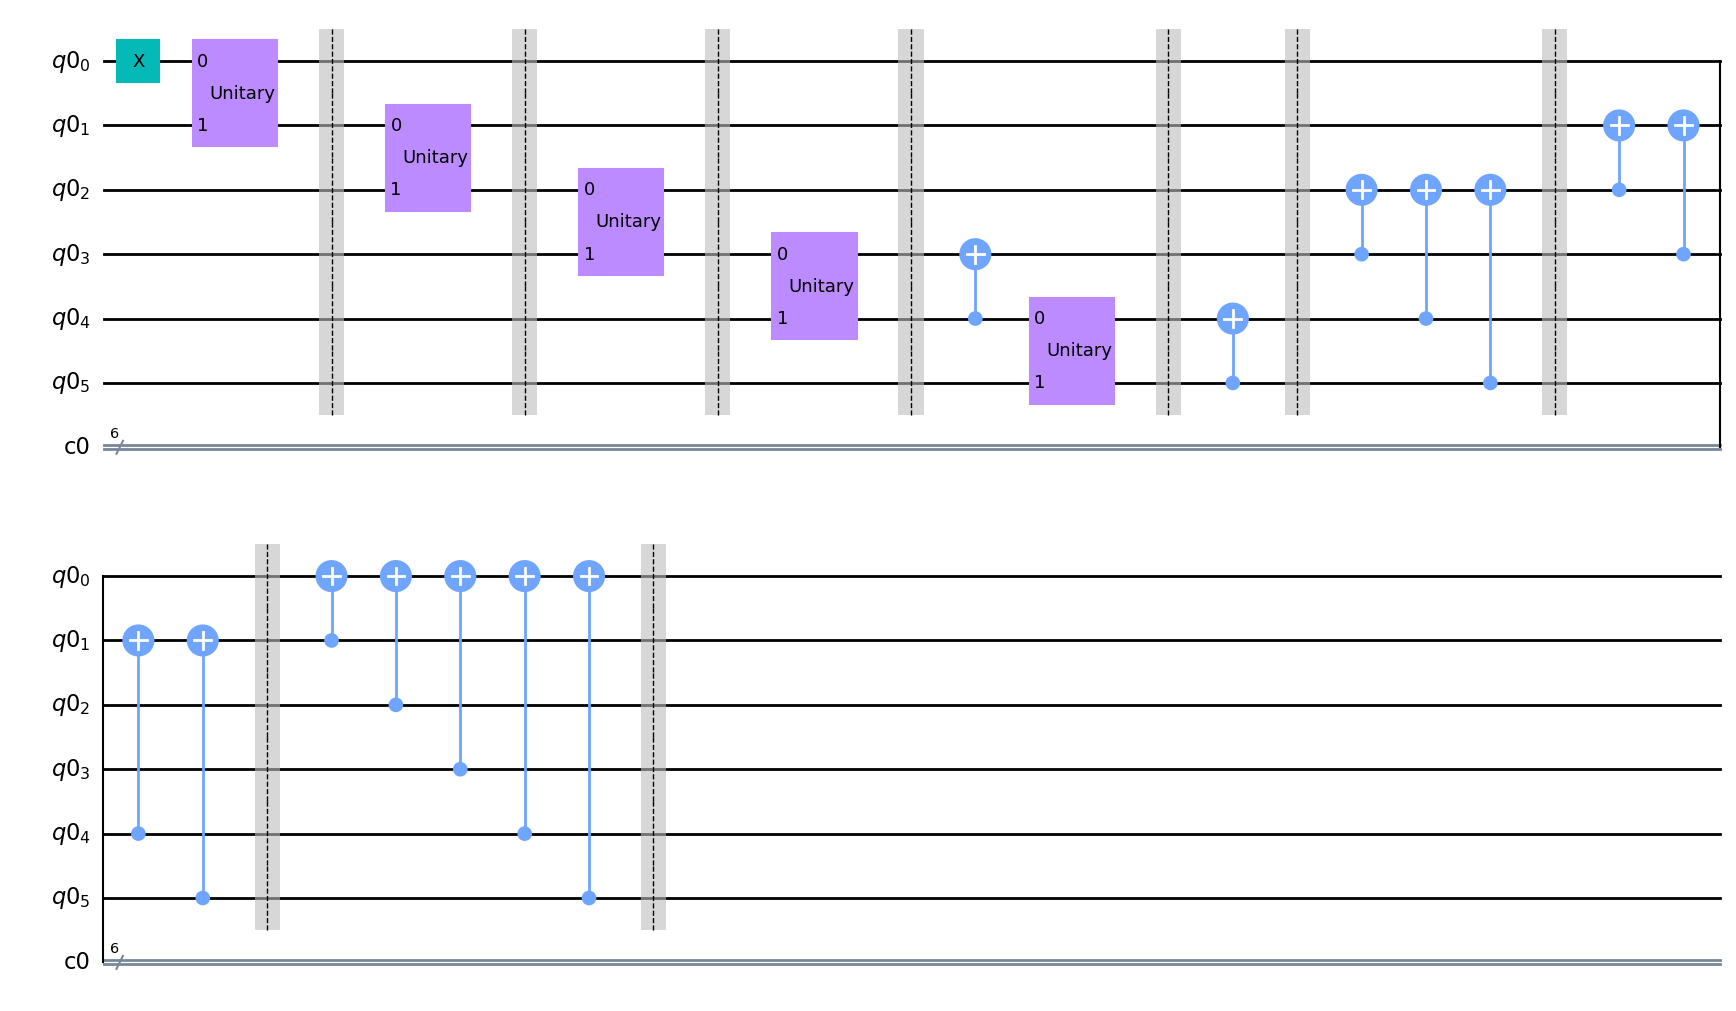

In [10]:
create_w_state(circ, q, 0, size)

circ.draw('mpl')

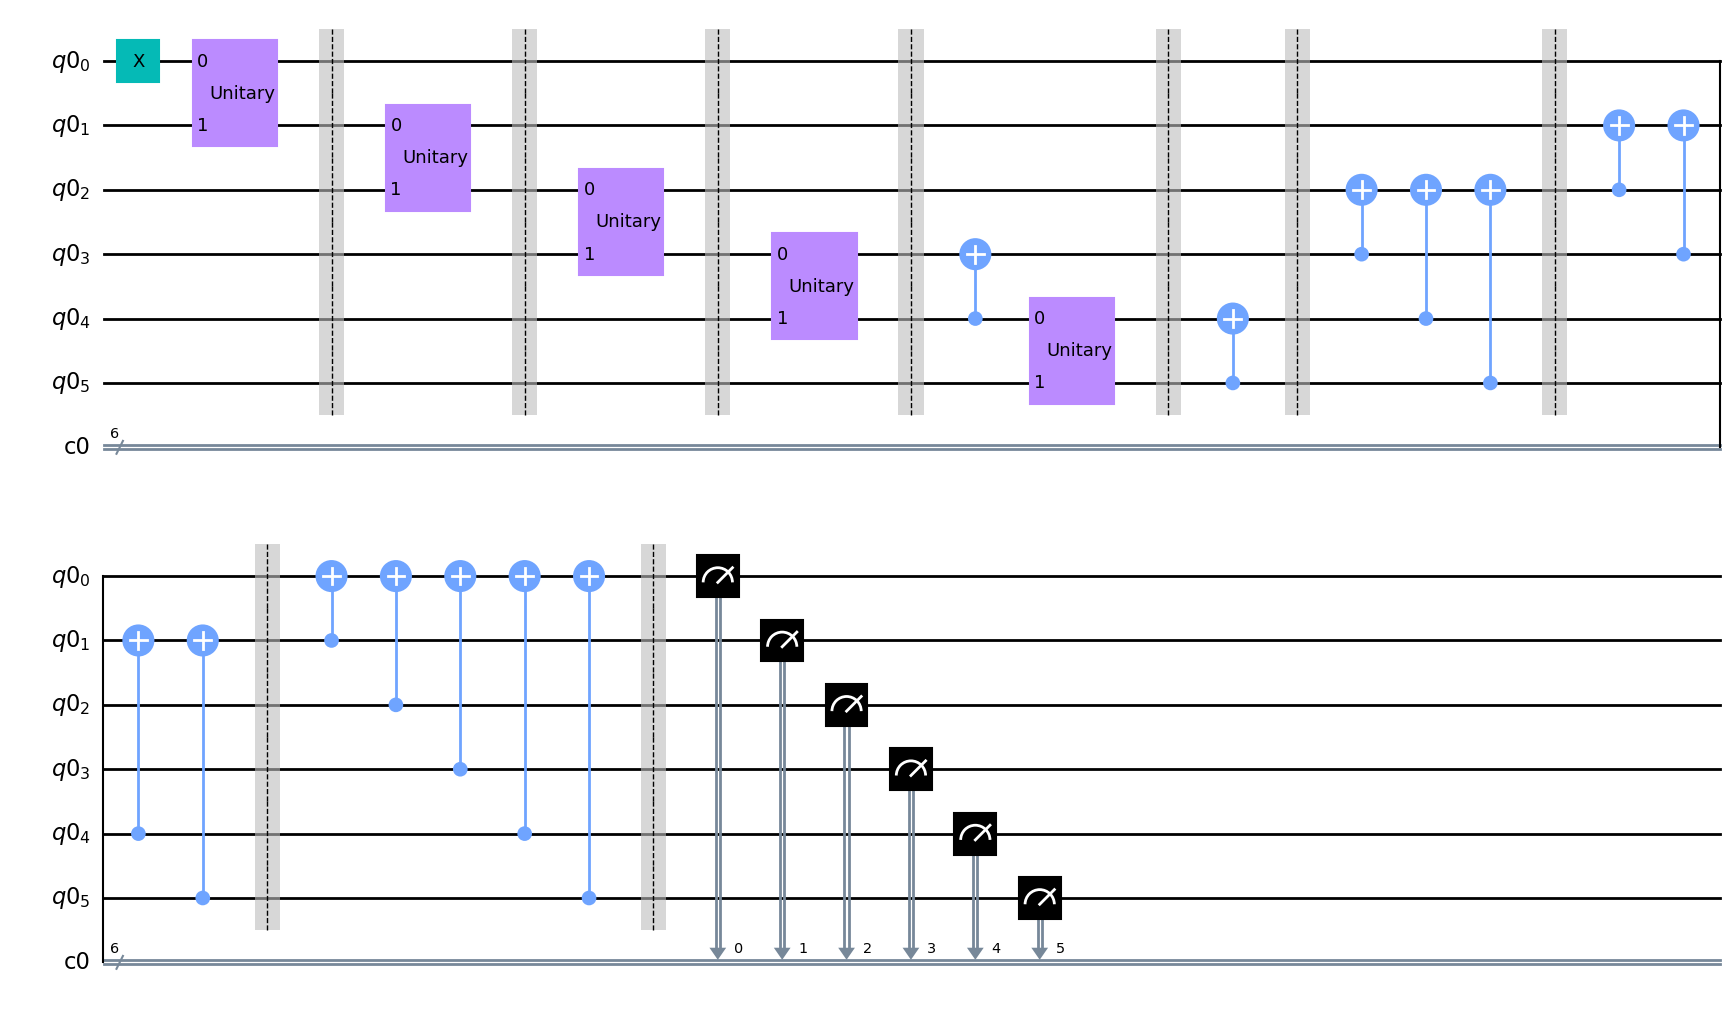

In [11]:
# Measure all qubits and put the result in the classical registers
count = 0

while count < size:
    circ.measure(q[count], c[count])
    count += 1

circ.draw('mpl',filename='dhondt-circ.png')

Node 0 became follower
Node 1 became follower
Node 2 became follower
Node 3 became follower
Node 4 became follower
Node 5 became leader


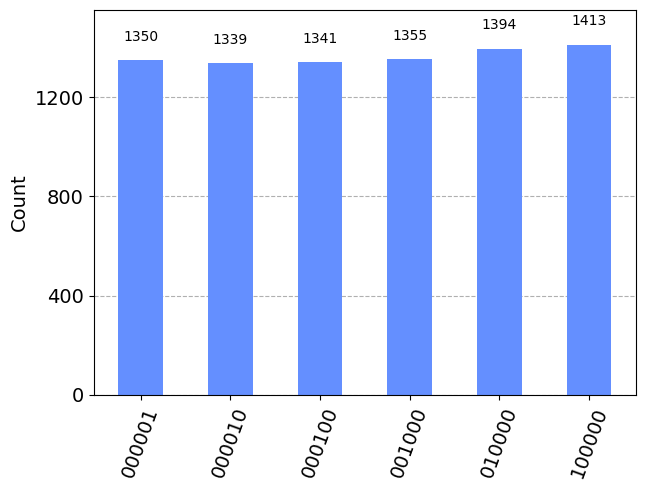

In [12]:
num_shots = 8192

# Create the simulator and run one time
backend_sim = BasicAer.get_backend('qasm_simulator')
job_sim = execute(circ, backend_sim, shots=num_shots, memory=True)
result_sim = job_sim.result().get_memory(circ)

# Print the results (Vermeij)
result = result_sim[0]
count = 0
while count < size:
    if result[count] == "1":
        sys.stdout.write("Node %s became leader\n" % str(count))
    else:
        sys.stdout.write("Node %s became follower\n" % str(count))
    count += 1

from qiskit.tools.visualization import plot_histogram
plot_histogram(job_sim.result().get_counts(circ))